In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import numpy.random as rnd
from PIL import Image

from antenna_utils import *
from plot_utils import *
from data_utils import *

# plt.rcParams['image.cmap'] = 'cubehelix'
plt.rcParams['image.cmap'] = 'afmhot'

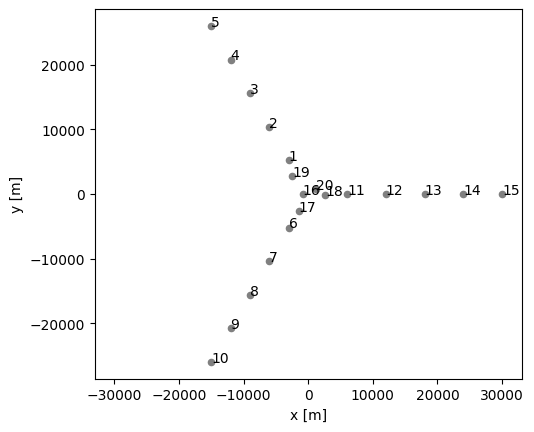

In [2]:
# Antenna parameters
x_lim = 30000
y_lim = 30000
n_antenna = 3*5
n_baselines = n_antenna*(n_antenna-1)
radius = 30000
alpha = 120
arr_center = random_antenna_arr(int(n_antenna/3), int(x_lim/5), int(y_lim/5))
# arr = radial_antenna_arr(n_antenna, x_lim, y_lim,radius)
arr = y_antenna_arr(int(n_antenna/3), radius, alpha)
arr = np.concatenate((arr,arr_center), axis=0)
plot_antenna_arr(arr)

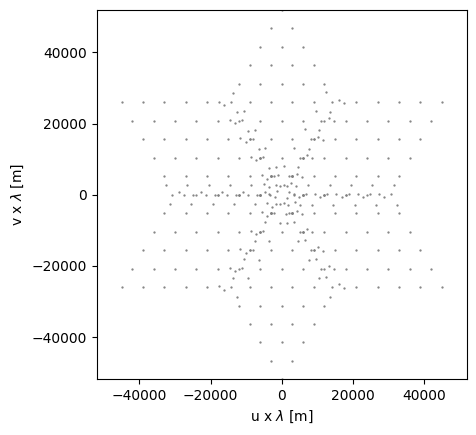

In [3]:
# Get baselines from array and plot
base_arr = get_baselines(arr)
plot_baselines(base_arr)

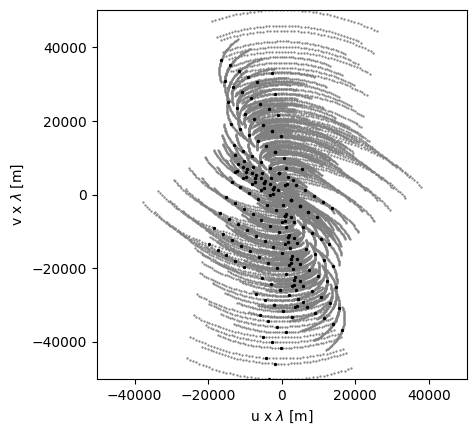

In [4]:
# Source tracking parameters
source_decl = 47/180*np.pi
array_lat = 19.1/180*np.pi
track_time = 4
delta_t = 5/60
t_0 = 3

# Get time integrated uv plane
track = uv_time_int(base_arr, array_lat, source_decl, track_time, delta_t, t_0)
plot_baselines(track, n_baselines)

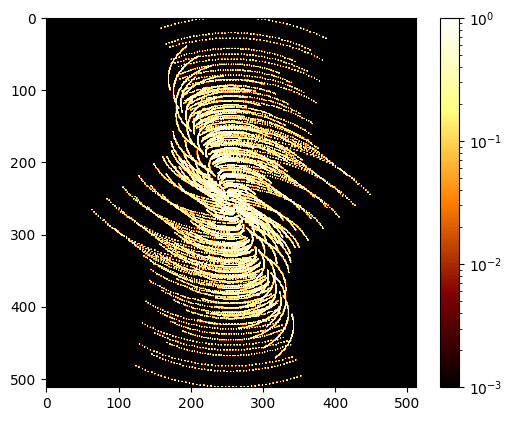

In [5]:
uv_dim = 512
uv_plane = get_uv_plane(track,uv_dim)
uv_plane_mask = get_uv_mask(uv_plane)
plot_sampled_sky(uv_plane_mask)

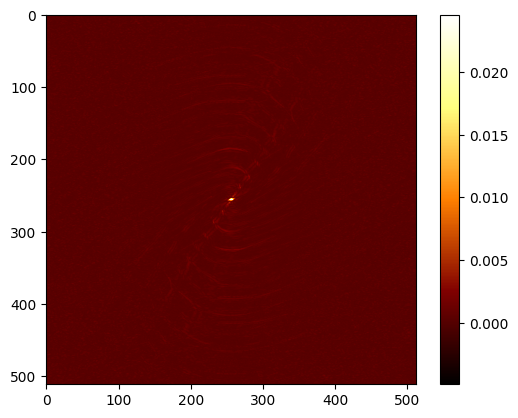

In [6]:
beam = get_beam(uv_plane_mask)
plot_beam(beam)


# Load Sky Model

In [7]:
# Sky model
nx = 512
ny = 512
pix_sizes = [10, 7, 10, 5]
amplitudes = [0.25, 0.25, 0.25, 0.25]
sky = n_source_sky((nx,ny), pix_sizes, amplitudes)

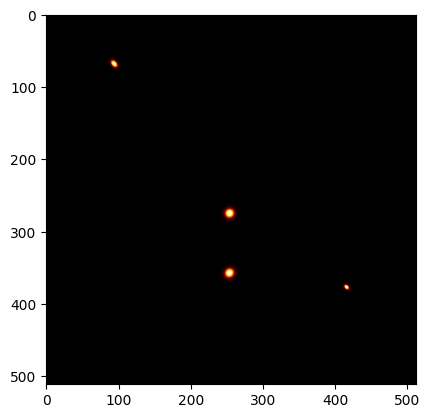

Image shape: (512, 512)
Image range: (0.0,0.24887813530284816)


In [8]:
plot_sky(sky)

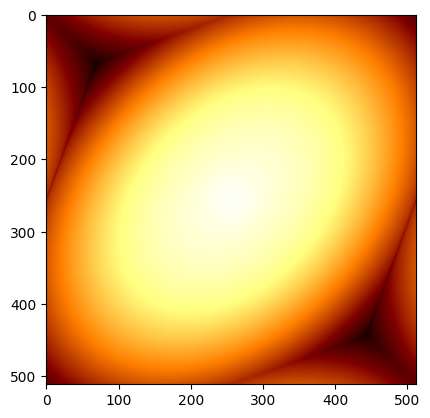

In [9]:
# pixScaleImg_asec = 5
# nX, nY = sky.shape
sky_uv = get_sky_uv(sky)
# modelFFTarr = np.fft.fftshift(modelFFTarr)
# pixScaleImg_lam = np.radians(pixScaleImg_asec/3600.0)
# fftScale_lam = 1.0/pixScaleImg_lam
# pixScaleFFTX_lam = 2.0*fftScale_lam/nX
# pixScaleFFTY_lam = 2.0*fftScale_lam/nY
plot_sky_uv(sky_uv)


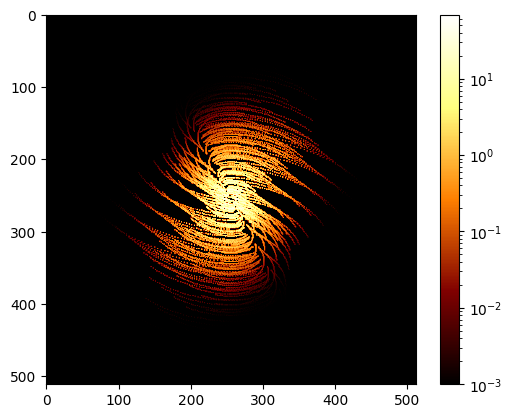

In [10]:
obs_uv = get_obs_uv(sky_uv,uv_plane_mask)
plot_sampled_sky(obs_uv)

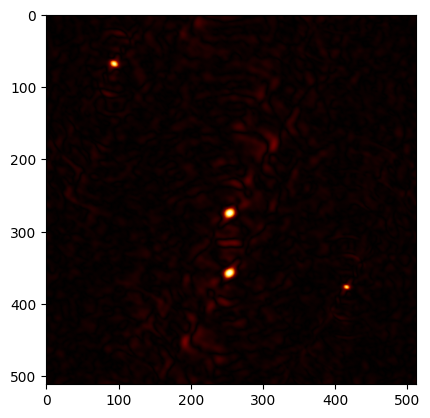

Image shape: (512, 512)
Image range: (3.7221491241175066e-06,0.09556933351280748)


In [11]:
obs_sky = get_obs_sky(obs_uv)
plot_sky(np.abs(obs_sky))

# Padding - Work in progress...

In [12]:
pad = 0
sky_pad = np.pad(sky, ((pad,pad),(pad,pad)), 'constant')
sky_uv = (np.fft.fft2(sky_pad))
crop = 10000#int(uv_dim/2)
sky_uv_crop = np.delete(np.delete(sky_uv,range(crop,len(sky_uv)-crop),1), range(crop,len(sky_uv)-crop), 0)
sky_uv_crop = (np.fft.fftshift(sky_uv_crop))

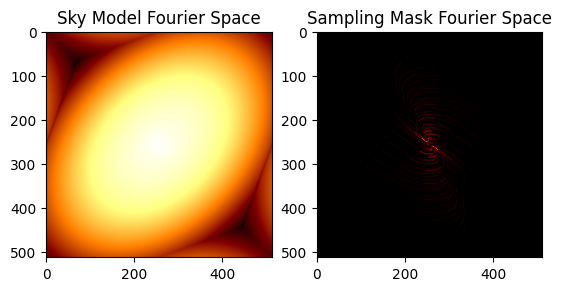

In [13]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.absolute(sky_uv_crop),norm=matplotlib.colors.LogNorm())
ax[0].set_title('Sky Model Fourier Space')
ax[1].imshow(uv_plane)
ax[1].set_title('Sampling Mask Fourier Space')
plt.show()

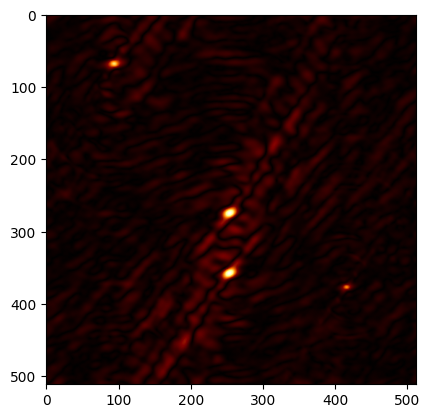

Image shape: (512, 512)
Image range: (6.488056249680943e-06,0.2853957325651806)


In [14]:
# Reconstruct sky
uv_sampled = np.multiply(sky_uv_crop, uv_plane)
sky_recovered = np.absolute(np.fft.ifft2((uv_sampled)))

plt.imshow(sky_recovered)
plt.show()
print('Image shape:', sky_recovered.shape)
print('Image range: ({},{})'.format(np.min(sky_recovered), np.max(sky_recovered)))

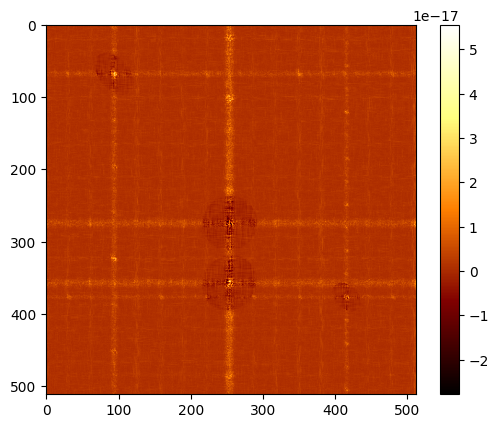

In [15]:
plt.imshow(np.absolute(np.fft.ifft2((sky_uv))) - sky)
plt.colorbar()